In [1]:
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
#read the csv
df = pd.read_csv('data/TrainingSet.csv')  # adjusted for project data folder
#print(df.shape)
df.head()

(274075, 8)


,Close Date,Close Price,Latitude,Longitude,Bedrooms,Bathrooms,Square Feet,Year Built
0,12/17/2024,4800.0,26.257621,-81.711571,4,3.0,2259,2004
1,12/17/2024,3700.0,34.041742,-84.044686,5,6.0,2951,2002
2,12/17/2024,2400.0,33.205474,-96.664503,4,2.0,1788,2000
3,12/17/2024,1770.0,27.756995,-82.648477,3,1.0,944,1955
4,12/17/2024,1995.0,32.627490,-97.328963,3,2.0,1360,2010


In [3]:
print("\nNulls per column:\n", df.isna().sum().sort_values(ascending=False))
df.info()


Nulls per column:
 Close Date     0
Close Price    0
Latitude       0
Longitude      0
Bedrooms       0
Bathrooms      0
Square Feet    0
Year Built     0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 274075 entries, 0 to 274074
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Close Date   274075 non-null  object 
 1   Close Price  274075 non-null  float64
 2   Latitude     274075 non-null  float64
 3   Longitude    274075 non-null  float64
 4   Bedrooms     274075 non-null  int64  
 5   Bathrooms    274075 non-null  float64
 6   Square Feet  274075 non-null  int64  
 7   Year Built   274075 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 16.7+ MB


In [4]:
# close date should be converted to datetime
df['Close Date'] = pd.to_datetime(df['Close Date'])
print(df.head())
df.info()

  Close Date  Close Price   Latitude  Longitude  Bedrooms  Bathrooms  \
0 2024-12-17       4800.0  26.257621 -81.711571         4        3.0   
1 2024-12-17       3700.0  34.041742 -84.044686         5        6.0   
2 2024-12-17       2400.0  33.205474 -96.664503         4        2.0   
3 2024-12-17       1770.0  27.756995 -82.648477         3        1.0   
4 2024-12-17       1995.0  32.627490 -97.328963         3        2.0   

   Square Feet  Year Built  
0         2259        2004  
1         2951        2002  
2         1788        2000  
3          944        1955  
4         1360        2010  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 274075 entries, 0 to 274074
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Close Date   274075 non-null  datetime64[ns]
 1   Close Price  274075 non-null  float64       
 2   Latitude     274075 non-null  float64       
 3   Longitude    274075 non-null

In [5]:
# Duplicate checks: rows & userId

dup_row_mask = df.duplicated(keep=False)
print(f"Duplicate rows (including first occurrences): {int(dup_row_mask.sum())}")
if dup_row_mask.any():
    print("Showing up to 10 duplicate rows:")
    display(df[dup_row_mask].head(10))

Duplicate rows (including first occurrences): 0


In [6]:
target_col = "Close Price"  


Min Close Date: 2023-01-19 00:00:00
Max Close Date: 2024-12-17 00:00:00


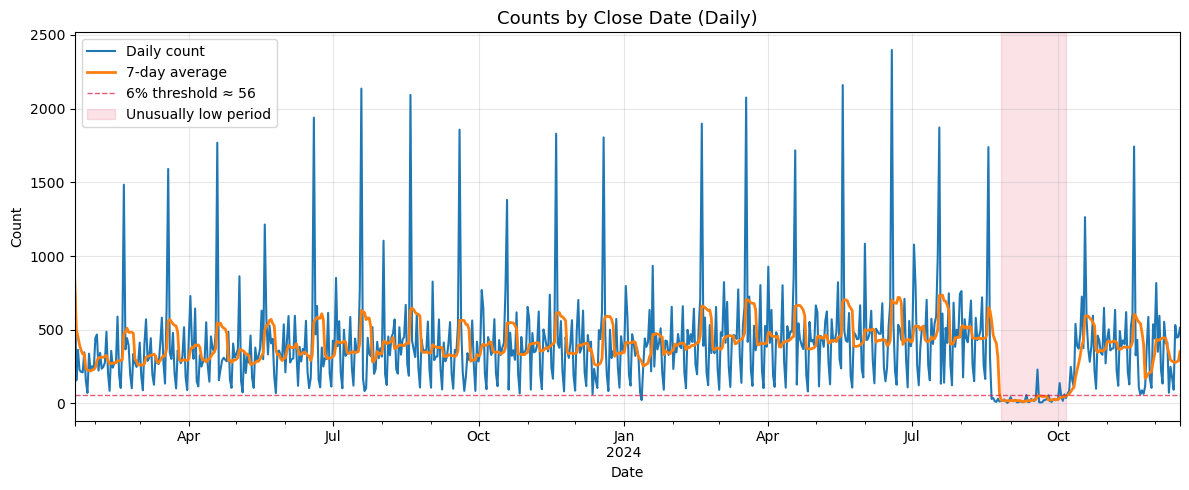


UNUSUALLY LOW PERIODS (rolling-7 < 56.0)

Period 1:
  Start: 2024-08-26
  End:   2024-10-06
  Duration: 42 days
  Avg daily count: 30.4



In [7]:
#Lets print the max and min dates in the dataset
print("Min Close Date:", df['Close Date'].min())
print("Max Close Date:", df['Close Date'].max())

# Time series of listing counts grouped by date
# (uses the Close Date column that was parsed earlier)


df_dates = df.copy()

# Aggregate by day
# Set Close Date as index so we can resample to daily frequency
daily_counts = (
    df_dates.set_index('Close Date')
            .resample('D')
            .size()
            .rename('count')
)

# Optional smoothed trend (7-day rolling average)
rolling7 = daily_counts.rolling(7, min_periods=1).mean()

# Compute a simple "unusually low" threshold using 15th percentile of rolling avg
p_val = 0.06
low_threshold = rolling7.quantile(p_val)
low_mask = rolling7 < low_threshold

# Find contiguous low ranges for shading
low_ranges = []
start = None
prev_idx = None
for idx, is_low in low_mask.items():
    if is_low and start is None:
        start = idx
    if start is not None and (not is_low or (prev_idx is not None and (idx - prev_idx).days > 1)):
        # close the previous run at prev_idx
        if prev_idx is not None:
            low_ranges.append((start, prev_idx))
        start = idx if is_low else None
    prev_idx = idx
# Close a trailing run
if start is not None and prev_idx is not None:
    low_ranges.append((start, prev_idx))

# Plot
import matplotlib.patches as mpatches
fig, ax = plt.subplots(figsize=(12, 5))

daily_counts.plot(ax=ax, color='tab:blue', linewidth=1.5, label='Daily count')
rolling7.plot(ax=ax, color='tab:orange', linewidth=2, label='7-day average')

# Draw threshold and shade low ranges
ax.axhline(low_threshold, color='crimson', linestyle='--', linewidth=1, alpha=0.7, label=f'{int(p_val*100)}% threshold ≈ {low_threshold:.0f}')
for s, e in low_ranges:
    ax.axvspan(s, e, color='crimson', alpha=0.12)

ax.set_title('Counts by Close Date (Daily)', fontsize=13)
ax.set_xlabel('Date')
ax.set_ylabel('Count')
ax.grid(True, alpha=0.3)

# Add a legend entry for shaded bands
low_patch = mpatches.Patch(color='crimson', alpha=0.12, label='Unusually low period')
handles, labels = ax.get_legend_handles_labels()
handles.append(low_patch)
labels.append('Unusually low period')
ax.legend(handles=handles, labels=labels)

plt.tight_layout()
plt.show()

# Print the date ranges for unusually low periods
print(f"\n{'='*60}")
print(f"UNUSUALLY LOW PERIODS (rolling-7 < {low_threshold:.1f})")
print(f"{'='*60}")
if low_ranges:
    for i, (start_date, end_date) in enumerate(low_ranges, 1):
        duration_days = (end_date - start_date).days + 1
        avg_count = daily_counts.loc[start_date:end_date].mean()
        print(f"\nPeriod {i}:")
        print(f"  Start: {start_date.strftime('%Y-%m-%d')}")
        print(f"  End:   {end_date.strftime('%Y-%m-%d')}")
        print(f"  Duration: {duration_days} days")
        print(f"  Avg daily count: {avg_count:.1f}")
else:
    print("\nNo unusually low periods detected.")
print(f"{'='*60}\n")


The dataset only covers a two year period during 2023 and 2024.

we also see a large drop in sales 

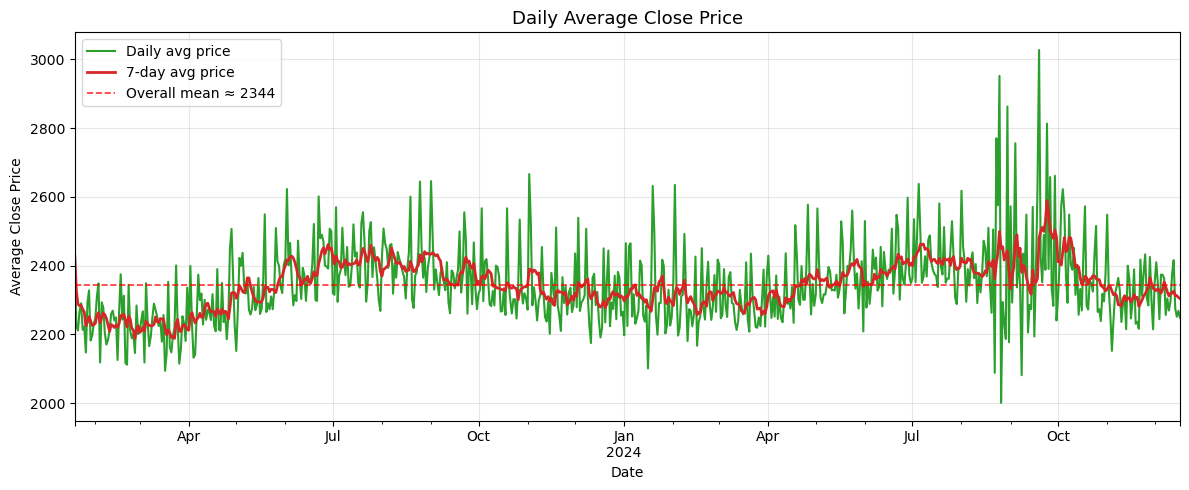

In [8]:
# now lets do the same with average close price
# We compute daily average Close Price, a 7-day rolling mean, and mark unusually low periods

price_series = (
    df.set_index('Close Date')['Close Price']
      .resample('D')
      .mean()
      .rename('avg_price')
)

rolling7_price = price_series.rolling(7, min_periods=1).mean()

# Overall mean of daily average price for reference line
overall_mean_price = price_series.mean()

fig, ax = plt.subplots(figsize=(12,5))
price_series.plot(ax=ax, color='tab:green', linewidth=1.5, label='Daily avg price')
rolling7_price.plot(ax=ax, color='tab:red', linewidth=2, label='7-day avg price')

# Horizontal line for overall mean
ax.axhline(overall_mean_price, color='red', linestyle='--', linewidth=1.2, alpha=0.8,
           label=f'Overall mean ≈ {overall_mean_price:.0f}')

ax.set_title('Daily Average Close Price', fontsize=13)
ax.set_xlabel('Date')
ax.set_ylabel('Average Close Price')
ax.grid(True, alpha=0.3)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels)
plt.tight_layout()
plt.show()



We notice the average close price has been fairly stable with an expected seasonal trend where prices rise in summer and dip in winter.

https://www.apartmentlist.com/research/best-time-of-year-to-rent

This leads me to believe adding a column to df for month of close date could capture this trend.


In [9]:
# lets add a column for month of close date
df['Close Month'] = df['Close Date'].dt.month
print(df.head()) 

  Close Date  Close Price   Latitude  Longitude  Bedrooms  Bathrooms  \
0 2024-12-17       4800.0  26.257621 -81.711571         4        3.0   
1 2024-12-17       3700.0  34.041742 -84.044686         5        6.0   
2 2024-12-17       2400.0  33.205474 -96.664503         4        2.0   
3 2024-12-17       1770.0  27.756995 -82.648477         3        1.0   
4 2024-12-17       1995.0  32.627490 -97.328963         3        2.0   

   Square Feet  Year Built  Close Month  
0         2259        2004           12  
1         2951        2002           12  
2         1788        2000           12  
3          944        1955           12  
4         1360        2010           12  


In [10]:
# lets also visualize average close price by 


Close Price : n=274075, mean=2.35e+03, std=817, min=400, 25%=1.86e+03, 50%=2.2e+03, 75%=2.6e+03, max=1e+04


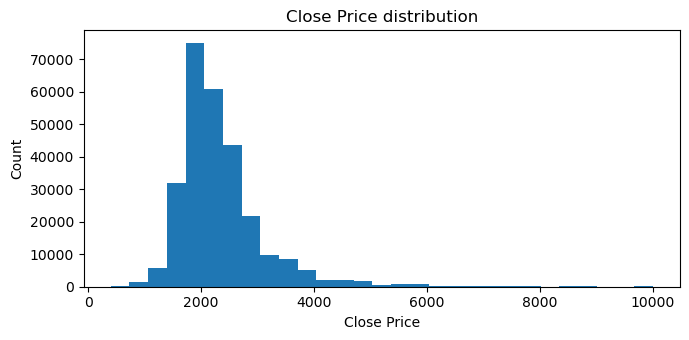


Bedrooms : n=274075, mean=3.45, std=0.925, min=1, 25%=3, 50%=3, 75%=4, max=222


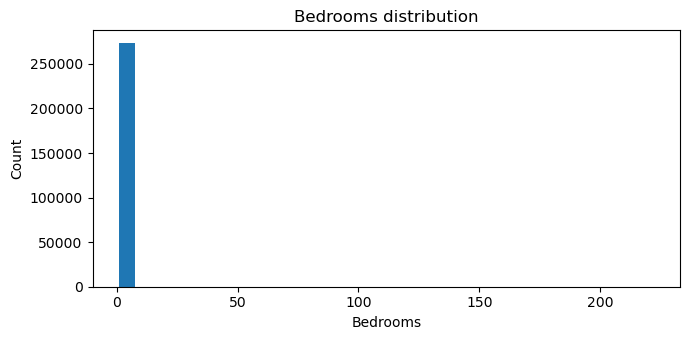


Bathrooms : n=274075, mean=2.37, std=0.833, min=0.1, 25%=2, 50%=2, 75%=3, max=205


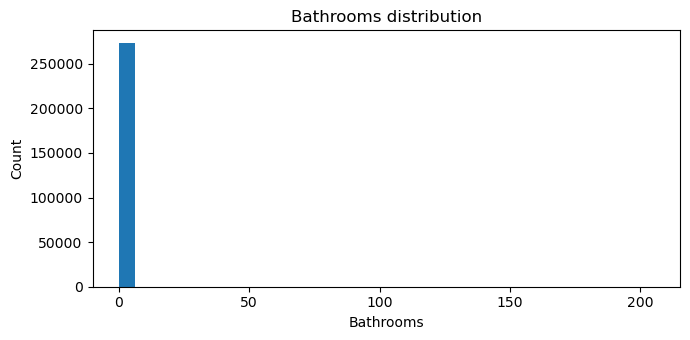


Square Feet : n=274075, mean=2.01e+03, std=3.3e+04, min=-36, 25%=1.48e+03, 50%=1.81e+03, 75%=2.24e+03, max=1.24e+07


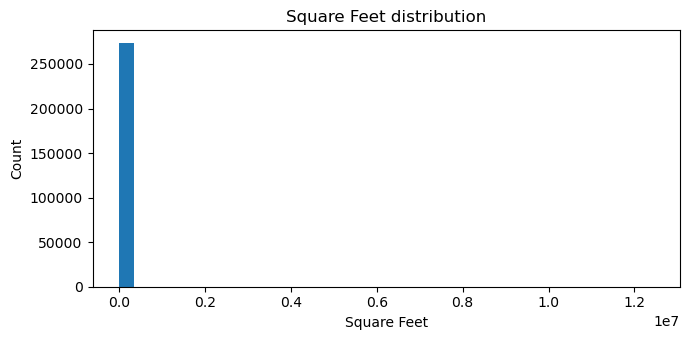


Year Built : n=274075, mean=2e+03, std=20.5, min=1.8e+03, 25%=1.98e+03, 50%=2e+03, 75%=2.01e+03, max=2.02e+03


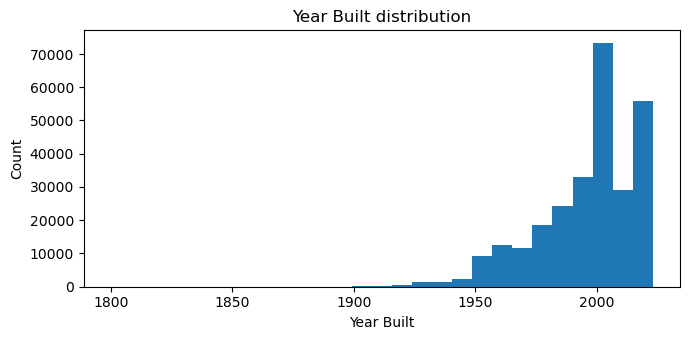


Close Month : n=274075, mean=6.42, std=3.28, min=1, 25%=4, 50%=6, 75%=9, max=12


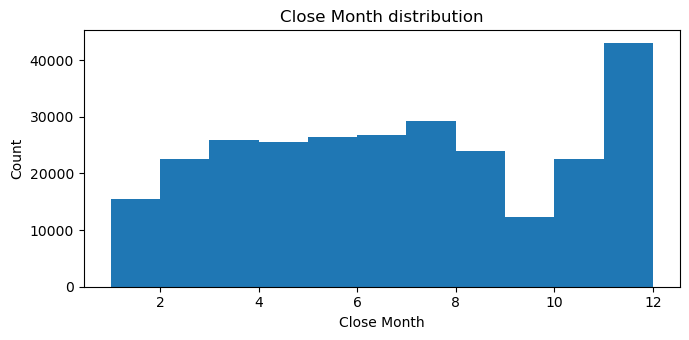

In [11]:
# Distributions for estimatedAnnualIncome, visitCount, scrollDepth

#num_cols are all except Close Date.
num_cols = [col for col in df.columns if col not in ("Close Date", 'Latitude', 'Longitude')]

for col in num_cols:
    if col not in df.columns:
        print(f"{col} not found; skipping.")
        continue

    num_col_series = pd.to_numeric(df[col], errors="coerce").dropna()
    if num_col_series.empty:
        print(f"{col}: no numeric values after coercion; skipping.")
        continue

    # Quick stats
    print(
        f"\n{col} : n={len(num_col_series)}, mean={num_col_series.mean():.3g}, std={num_col_series.std(ddof=1):.3g}, "
        f"min={num_col_series.min():.3g}, 25%={num_col_series.quantile(0.25):.3g}, "
        f"50%={num_col_series.median():.3g}, 75%={num_col_series.quantile(0.75):.3g}, max={num_col_series.max():.3g}"
    )

    # Histogram (linear x-axis)
    plt.figure(figsize=(7, 3.5))
    plt.hist(num_col_series, bins="doane")
    plt.title(f"{col} distribution")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

In [12]:
# wee see some really heavy outliers for sq footage, bathrooms and bedrooms. Let's look at those more closely.
for col in ["Bedrooms","Bathrooms","Square Feet"]:
    num_col_series = pd.to_numeric(df[col], errors="coerce").dropna()
    # Show top 10 values
    print(f"\nTop 10 highest values for {col}:")
    display(num_col_series.sort_values(ascending=False).head(10))


Top 10 highest values for Bedrooms:


70606     222
49828      58
118309     52
166623     47
44902      40
6768       33
14282      32
209088     31
35103      30
209619     30
Name: Bedrooms, dtype: int64


Top 10 highest values for Bathrooms:


93331     205.0
38569      71.0
255898     25.0
182213     25.0
66855      25.0
127107     25.0
96159      23.0
99221      22.0
217456     22.0
186003     21.1
Name: Bathrooms, dtype: float64


Top 10 highest values for Square Feet:


21157     12441289
11946     11981538
82400        33341
248292       31020
196102       25488
31697        21409
37417        19526
14410        19524
3328         19512
36604        19501
Name: Square Feet, dtype: int64

Bedrooms: 1% cutoff = 2, 99% cutoff = 6; kept 271490 / 274075 (99.1%).


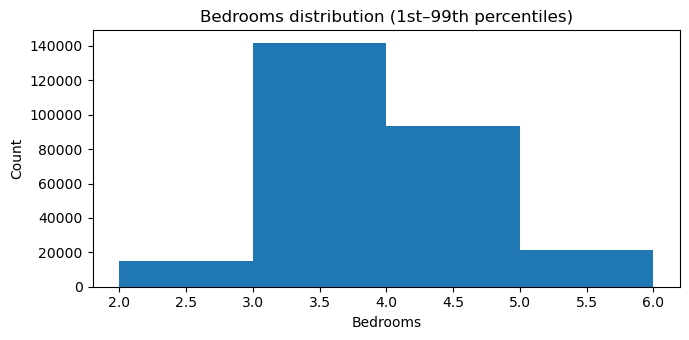

Bathrooms: 1% cutoff = 1, 99% cutoff = 4.1; kept 271326 / 274075 (99.0%).


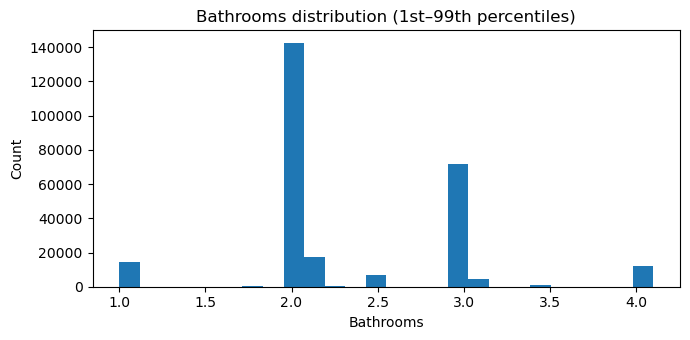

Square Feet: 1% cutoff = 803, 99% cutoff = 4.09e+03; kept 268605 / 274075 (98.0%).


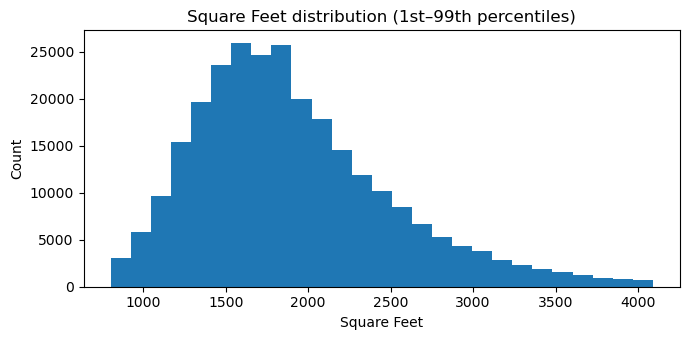

In [13]:
# Filter to values between 1st and 99th percentiles (double-tail cutoff) and plot distributions
for col in ["Bedrooms","Bathrooms","Square Feet"]:
    if col not in df.columns:
        print(f"{col} not found; skipping.")
        continue

    num_col_series = pd.to_numeric(df[col], errors="coerce").dropna()
    if num_col_series.empty:
        print(f"{col}: no numeric values after coercion; skipping.")
        continue

    # Double-tail cutoff: keep middle 98% (1st to 99th percentiles)
    p_low = num_col_series.quantile(0.01)
    p_high = num_col_series.quantile(0.99)
    filtered_series = num_col_series[(num_col_series >= p_low) & (num_col_series <= p_high)]

    kept_pct = len(filtered_series) / len(num_col_series) * 100
    print(f"{col}: 1% cutoff = {p_low:.3g}, 99% cutoff = {p_high:.3g}; kept {len(filtered_series)} / {len(num_col_series)} ({kept_pct:.1f}%).")

    plt.figure(figsize=(7, 3.5))
    plt.hist(filtered_series, bins="doane")
    plt.title(f"{col} distribution (1st–99th percentiles)")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

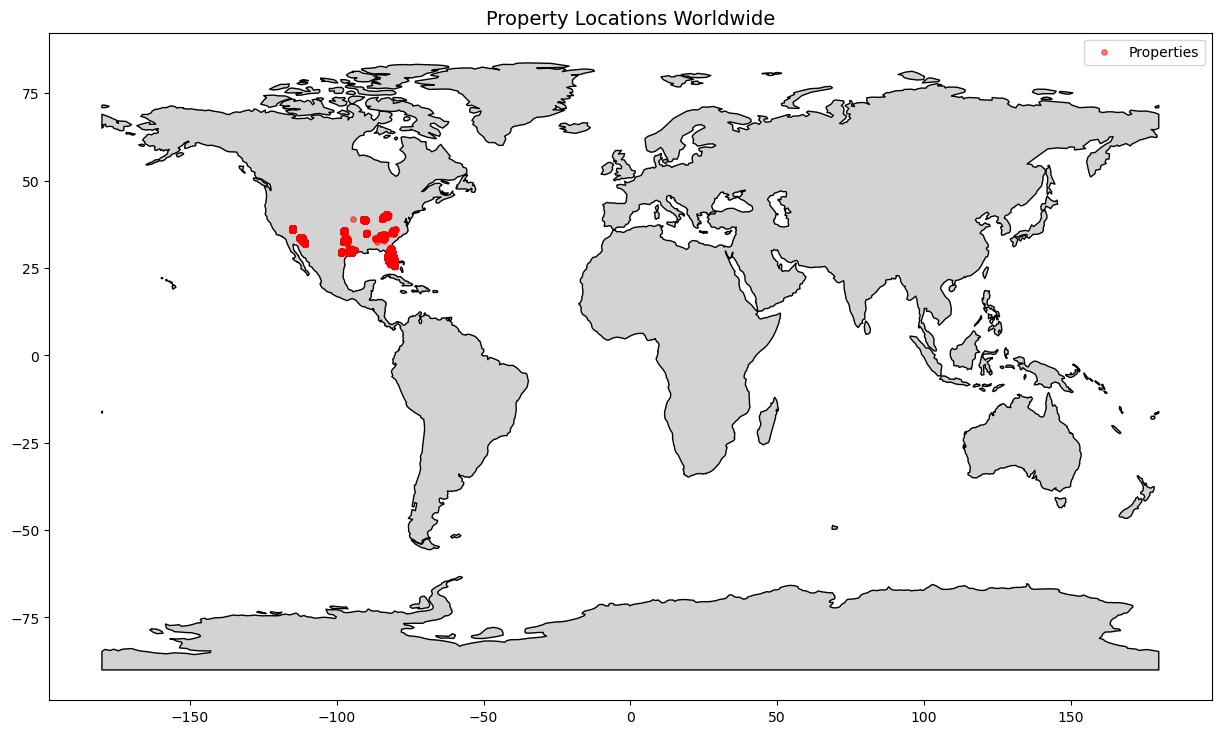

In [14]:
#Lets plot the latitude and longitude of properties on a map of the world with geometris to see if there are any geographic patterns.
# We can use geopandas for this.
import geopandas as gpd
import geodatasets
from shapely.geometry import Point

# Create a GeoDataFrame with explicit CRS (WGS84)
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')

# Load world map
world = gpd.read_file(geodatasets.get_path("naturalearth.land"))

# Create plot with higher resolution
fig, ax = plt.subplots(figsize=(15, 10))

# Plot base world map
world.plot(ax=ax, color='lightgray',edgecolor='black')

# Plot points with styling for visibility
gdf.plot(ax=ax, color='red', markersize=15, alpha=0.5, marker='o', label='Properties')

# Add title and legend
plt.title('Property Locations Worldwide', fontsize=14)
plt.legend()


plt.show()

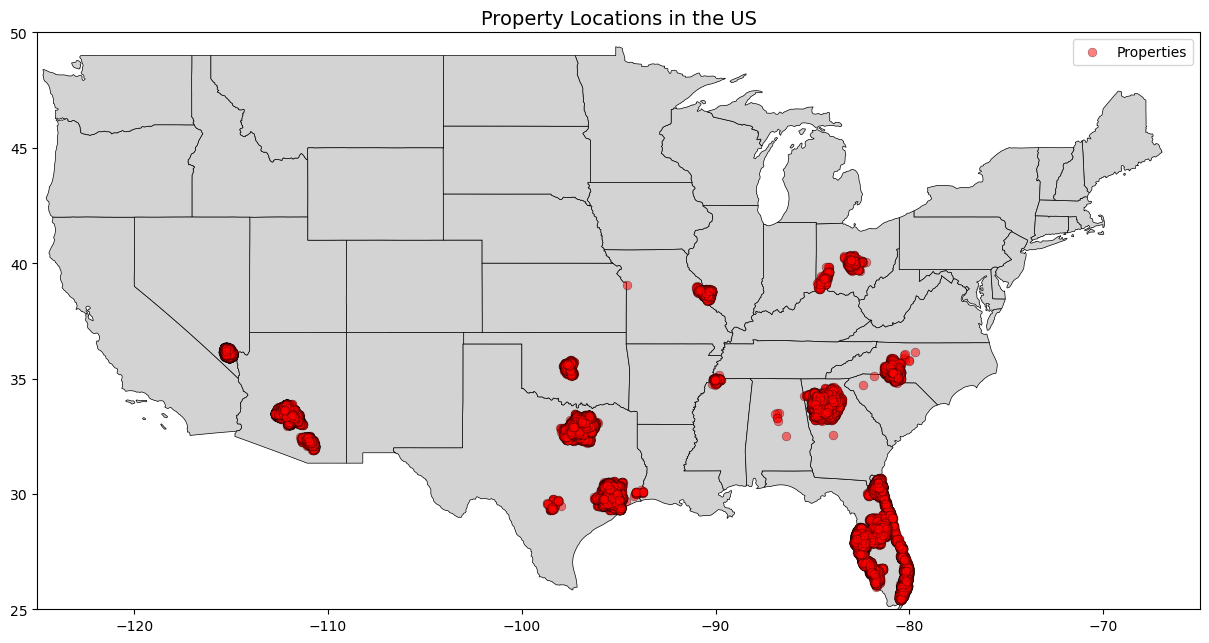

In [15]:
# notice all the points are in the US. Let's zoom into a plot of the US.
# Load US map
usa = gpd.read_file(geodatasets.get_path('geoda.us_sdoh'))  # Using a US-specific dataset for better resolution 
# Create plot
states = gpd.read_file('https://www2.census.gov/geo/tiger/GENZ2020/shp/cb_2020_us_state_20m.zip')

# Create plot
fig, ax = plt.subplots(figsize=(15, 10))

# Plot US states
states.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=0.5)

# Plot property points
gdf.plot(ax=ax, color='red', edgecolor='black', linewidth=0.35, markersize=40, alpha=0.5, marker='o', label='Properties')

# Set the map extent to continental US
plt.xlim(-125, -65)
plt.ylim(25, 50)

# Add title and legend
plt.title('Property Locations in the US', fontsize=14)
plt.legend()

plt.show()

In [16]:
#lets add a column to df with the State code for each property.
# We can use the reverse geocoding capabilities of geopandas to do this.
# # last cell we created a states object and we will simply use that here
from shapely.geometry import Point
import geopandas as gpd
import pandas as pd     
# Create a GeoDataFrame for the properties
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')
# Load US states
states = gpd.read_file('https://www2.census.gov/geo/tiger/GENZ2020/shp/cb_2020_us_state_20m.zip')
# Ensure both GeoDataFrames use the same CRS
gdf = gdf.to_crs(states.crs)
# Perform spatial join to get state information for each property
gdf_with_state = gpd.sjoin(gdf, states[['STUSPS', 'geometry']], how='left')
# Rename the state code column
gdf_with_state.rename(columns={'STUSPS': 'State'}, inplace=True)
# Display the first few rows to verify
print(gdf_with_state[['Latitude', 'Longitude', 'State']].head())
# Now gdf_with_state has a 'State' column with the state code for each property.
# If you want to convert it back to a regular DataFrame without geometry:
df_with_state = pd.DataFrame(gdf_with_state.drop(columns='geometry'))
print(df_with_state[['Latitude', 'Longitude', 'State']].head())  
# and then add this as a column to the original df
df['State'] = df_with_state['State']
df.head()        

    Latitude  Longitude State
0  26.257621 -81.711571    FL
1  34.041742 -84.044686    GA
2  33.205474 -96.664503    TX
3  27.756995 -82.648477    FL
4  32.627490 -97.328963    TX
    Latitude  Longitude State
0  26.257621 -81.711571    FL
1  34.041742 -84.044686    GA
2  33.205474 -96.664503    TX
3  27.756995 -82.648477    FL
4  32.627490 -97.328963    TX


,Close Date,Close Price,Latitude,Longitude,Bedrooms,Bathrooms,Square Feet,Year Built,Close Month,State
0,2024-12-17,4800.0,26.257621,-81.711571,4,3.0,2259,2004,12,FL
1,2024-12-17,3700.0,34.041742,-84.044686,5,6.0,2951,2002,12,GA
2,2024-12-17,2400.0,33.205474,-96.664503,4,2.0,1788,2000,12,TX
3,2024-12-17,1770.0,27.756995,-82.648477,3,1.0,944,1955,12,FL
4,2024-12-17,1995.0,32.627490,-97.328963,3,2.0,1360,2010,12,TX


Total unique states: 15


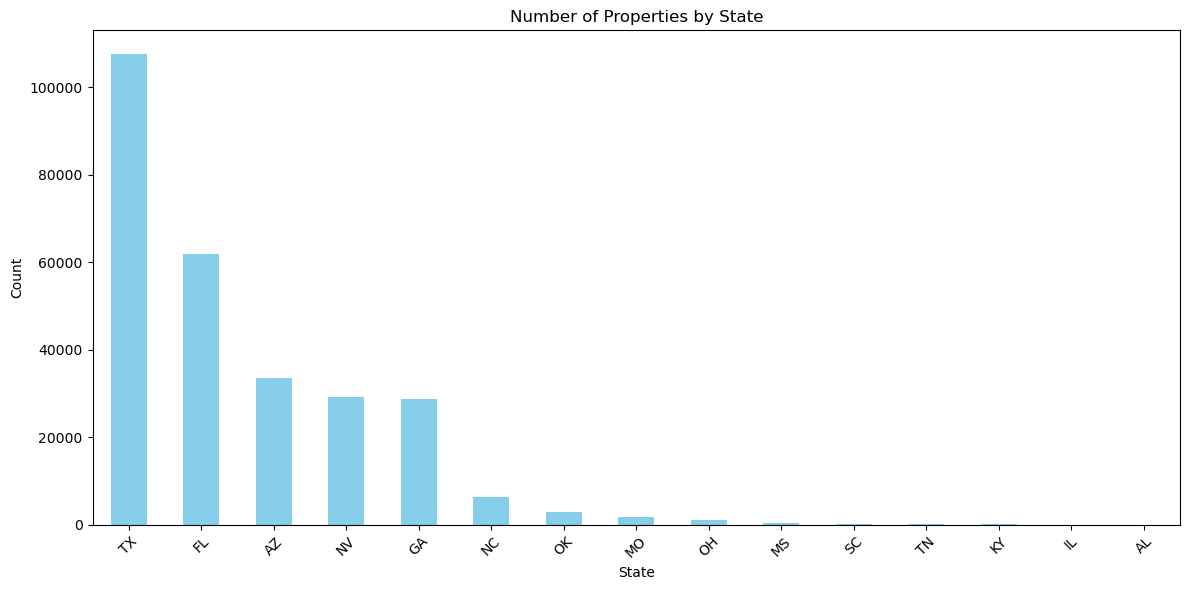

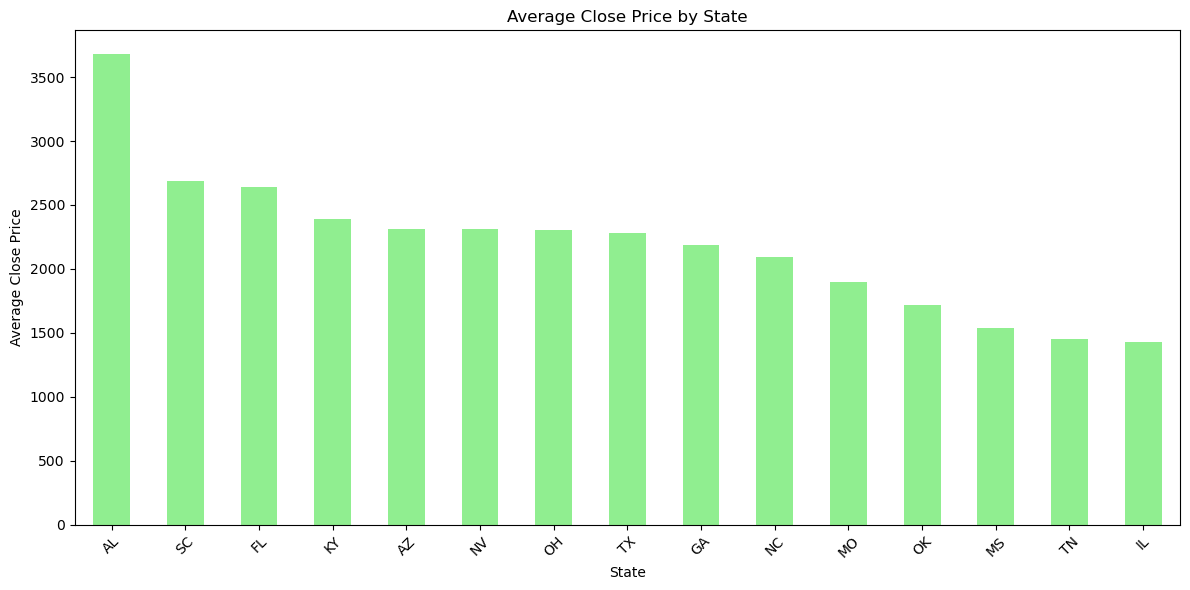

In [17]:
#lets print the total number of unique states
print(f"Total unique states: {df['State'].nunique()}") 
# lets visualize the counts grouped by state
state_counts = df['State'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
state_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Properties by State')
plt.xlabel('State')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
#as well as the distribution of average close price by state
avg_price_state = df.groupby('State')['Close Price'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
avg_price_state.plot(kind='bar', color='lightgreen')
plt.title('Average Close Price by State')
plt.xlabel('State')
plt.ylabel('Average Close Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()  

In [18]:
# Zillow ZIP-level dataset (one-bedroom) wide -> long + month-end merge
zillow_data_zip = pd.read_csv('data/Zip_zhvi_bdrmcnt_1_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv')
print("Raw Zillow shape:", zillow_data_zip.shape)
print(zillow_data_zip.head())

import re
from shapely.geometry import Point
import geopandas as gpd

# 1) Ensure df has a Zipcode column; derive from ZCTA if missing
if ('Zipcode' not in df.columns) or (df['Zipcode'].isna().any()):
    coord_mask = df[['Latitude', 'Longitude']].notna().all(axis=1)
    if coord_mask.any():
        try:
            gdf_pts = gpd.GeoDataFrame(
                df.loc[coord_mask].copy(),
                geometry=[Point(xy) for xy in zip(df.loc[coord_mask, 'Longitude'], df.loc[coord_mask, 'Latitude'])],
                crs='EPSG:4326'
            )
            # Use the 500k generalized ZCTA shapefile (20m version 404s in this environment)
            zcta_url = 'https://www2.census.gov/geo/tiger/GENZ2020/shp/cb_2020_us_zcta520_500k.zip'
            zcta = gpd.read_file(zcta_url)
            if zcta.crs is None:
                zcta = zcta.set_crs('EPSG:4269')  # NAD83
            zcta = zcta.to_crs(gdf_pts.crs)
            cand_cols = ['ZCTA5CE20', 'ZCTA5CE10', 'GEOID', 'ZCTA5']
            zcta_col = next((c for c in cand_cols if c in zcta.columns), None)
            if zcta_col is None:
                raise ValueError(f"No ZCTA code column found in ZCTA layer. Columns: {list(zcta.columns)}")
            joined = gpd.sjoin(gdf_pts, zcta[[zcta_col, 'geometry']], how='left', predicate='intersects')
            df.loc[coord_mask, 'Zipcode'] = joined[zcta_col].astype(str).str.zfill(5).values
        except Exception as e:
            print("Warning: Failed ZCTA spatial join:", e)
            # Fallback: leave Zipcode missing; will skip merge gracefully later

if 'Zipcode' not in df.columns:
    print("Zipcode column still missing; Zillow merge will be skipped.")

# Normalize Zip format if present
df['Zipcode'] = df.get('Zipcode', pd.Series([None]*len(df))).astype(str).str.zfill(5)

# 2) Zillow file is wide -> melt to long
meta_cols = {"RegionID","SizeRank","RegionName","RegionType","StateName","State","City","Metro","CountyName"}
month_cols = [c for c in zillow_data_zip.columns if re.fullmatch(r"\d{4}-\d{2}-\d{2}", c)]
if not month_cols:
    raise ValueError("No YYYY-MM-DD month columns detected in Zillow data.")

zillow_long = (
    zillow_data_zip
      .melt(id_vars=sorted(meta_cols & set(zillow_data_zip.columns)), value_vars=month_cols,
            var_name="Date", value_name="ZillowValue")
)
zillow_long['Date'] = pd.to_datetime(zillow_long['Date'])

# Derive Zipcode from RegionName where RegionType == 'zip' and zero-pad
if 'RegionType' in zillow_long.columns and 'RegionName' in zillow_long.columns:
    zip_mask = zillow_long['RegionType'].str.lower() == 'zip'
    zillow_long.loc[zip_mask, 'Zipcode'] = zillow_long.loc[zip_mask, 'RegionName'].astype(str).str.zfill(5)
else:
    raise ValueError("Missing RegionType/RegionName for ZIP derivation.")

zillow_long = zillow_long.dropna(subset=['Zipcode'])
print("Long Zillow shape:", zillow_long.shape)
print(zillow_long.head())

# 3) Ensure df has Close Date parsed and align to month end
if df['Close Date'].dtype != 'datetime64[ns]':
    df['Close Date'] = pd.to_datetime(df['Close Date'])

df['Close Month End'] = df['Close Date'] + pd.offsets.MonthEnd(0)

# 4) Merge only if Zipcode appears to have non-null values
if df['Zipcode'].notna().any():
    merged_df = pd.merge(
        df,
        zillow_long[['Zipcode','Date','ZillowValue']],
        left_on=['Zipcode','Close Month End'],
        right_on=['Zipcode','Date'],
        how='left'
    ).drop(columns=['Date'])
    match_rate = merged_df['ZillowValue'].notna().mean()
    print(f"Zillow match rate: {match_rate:.1%} ({merged_df['ZillowValue'].notna().sum()} / {len(merged_df)})")
else:
    print("No valid Zipcode values found; skipping Zillow merge.")
    merged_df = df.copy()
    merged_df['ZillowValue'] = pd.NA

print(merged_df.head())


Zillow match rate: 28.2% (77364 / 274075)
  Close Date  Close Price   Latitude  Longitude  Bedrooms  Bathrooms  \
0 2024-12-17       4800.0  26.257621 -81.711571         4        3.0   
1 2024-12-17       3700.0  34.041742 -84.044686         5        6.0   
2 2024-12-17       2400.0  33.205474 -96.664503         4        2.0   
3 2024-12-17       1770.0  27.756995 -82.648477         3        1.0   
4 2024-12-17       1995.0  32.627490 -97.328963         3        2.0   

   Square Feet  Year Built  Close Month State Zipcode Close Month End  \
0         2259        2004           12    FL   34119      2024-12-31   
1         2951        2002           12    GA   30024      2024-12-31   
2         1788        2000           12    TX   75071      2024-12-31   
3          944        1955           12    FL   33705      2024-12-31   
4         1360        2010           12    TX   76134      2024-12-31   

    ZillowValue  
0           NaN  
1           NaN  
2           NaN  
3  246634.6597

In [19]:
# Zillow state-level dataset (one-bedroom) wide -> long + month-end merge
zillow_data_state = pd.read_csv('data/State_zhvi_bdrmcnt_1_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv')
print("Raw Zillow shape:", zillow_data_state.shape)
print(zillow_data_state.head())
#we now pull in the zillow data by state and fill the missing zillow values according to state averages in a similar wayabs
zillow_long_state = (
    zillow_data_state
      .melt(id_vars=sorted(meta_cols & set(zillow_data_state.columns)), value_vars=month_cols,
            var_name="Date", value_name="ZillowValue")
)
zillow_long_state['Date'] = pd.to_datetime(zillow_long_state['Date'])
# Match RegionName which has the state name spelled out to its corresponding 2 letter state code. Ex: "California" -> "CA"
state_name_to_code = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA', 'Colorado': 'CO',
    'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID',
    'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA',
    'Maine': 'ME', 'Maryland': 'MD', 'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS',
    'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH',
    'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND',
    'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',         
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT',
    'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'
}
zillow_long_state['State'] = zillow_long_state['RegionName'].map(state_name_to_code)
zillow_long_state = zillow_long_state.dropna(subset=['State'])
print("Long Zillow shape:", zillow_long_state.shape)
print(zillow_long_state.head())
# Merge on State and month-end Close Date
merged_df_state = pd.merge(
    merged_df,
    zillow_long_state[['State','Date','ZillowValue']],
    left_on=['State','Close Month End'],
    right_on=['State','Date'],
    how='left',
    suffixes=('', '_State')
).drop(columns=['Date'])
state_match_rate = merged_df_state['ZillowValue_State'].notna().mean()
print(f"Zillow state match rate: {state_match_rate:.1%} ({merged_df_state['ZillowValue_State'].notna().sum()} / {len(merged_df_state)})")
print(merged_df_state.head())
# Fill missing ZIP-level Zillow values with state-level averages
merged_df_state['ZillowValue_Filled'] = merged_df_state['ZillowValue']
missing_zip_mask = merged_df_state['ZillowValue'].isna() & merged_df_state['ZillowValue_State'].notna()
merged_df_state.loc[missing_zip_mask, 'ZillowValue_Filled'] = merged_df_state.loc[missing_zip_mask, 'ZillowValue_State']
final_zip_fill_rate = merged_df_state['ZillowValue_Filled'].notna().mean()
print(f"Final Zillow fill rate after state fallback: {final_zip_fill_rate:.1%} ({merged_df_state['ZillowValue_Filled'].notna().sum()} / {len(merged_df_state)})")
print(merged_df_state.head())
# then drop close month end, zillow value state and zillow value
final_df = merged_df_state.drop(columns=['Close Month End', 'ZillowValue_State', 'ZillowValue'])
# rename the filled column to ZHI   
final_df.rename(columns={'ZillowValue_Filled': 'ZHI'}, inplace=True)
print(final_df.head())

Long Zillow shape: (15450, 8)
   RegionID    RegionName RegionType  SizeRank  StateName       Date  \
0         9    California      state         0        NaN 2000-01-31   
1        54         Texas      state         1        NaN 2000-01-31   
2        14       Florida      state         2        NaN 2000-01-31   
3        43      New York      state         3        NaN 2000-01-31   
4        47  Pennsylvania      state         4        NaN 2000-01-31   

     ZillowValue State  
0  115201.390052    CA  
1   68202.729439    TX  
2   51183.373568    FL  
3  132581.461484    NY  
4   61476.021413    PA  
Final Zillow fill rate after state fallback: 89.5% (245178 / 274075)
  Close Date  Close Price   Latitude  Longitude  Bedrooms  Bathrooms  \
0 2024-12-17       4800.0  26.257621 -81.711571         4        3.0   
1 2024-12-17       3700.0  34.041742 -84.044686         5        6.0   
2 2024-12-17       2400.0  33.205474 -96.664503         4        2.0   
3 2024-12-17       1770.0  27.

In [20]:
# Fast nearest transit stop distance using BallTree (haversine) for scalability
import pandas as pd
import numpy as np
from sklearn.neighbors import BallTree

# Choose base DataFrame (final enriched if exists)
base_df = final_df if 'final_df' in globals() else df

# Load and prep transit stops (lat/lon in radians)
transit_cols = ['OBJECTID','stop_lat','stop_lon']
transit_data = (
    pd.read_csv('data/NTAD_National_Transit_Map_Stops.csv', usecols=transit_cols)
      .dropna(subset=['stop_lat','stop_lon'])
)

# Filter valid property coordinates
coord_mask = base_df[['Latitude','Longitude']].notna().all(axis=1)
valid_df = base_df.loc[coord_mask, ['Latitude','Longitude']].copy()

if valid_df.empty:
    base_df['DistanceToTransit'] = np.nan
    print('No valid property coordinates; DistanceToTransit set to NA.')
else:
    # Convert degrees -> radians for haversine BallTree
    prop_rad = np.radians(valid_df[['Latitude','Longitude']].values)
    stops_rad = np.radians(transit_data[['stop_lat','stop_lon']].values)

    # Build BallTree (haversine distances on unit sphere)
    tree = BallTree(stops_rad, metric='haversine')

    # Query nearest stop (returns distance in radians); multiply by earth radius (meters)
    earth_radius_m = 6371000.0
    dist_rad, _ = tree.query(prop_rad, k=1)
    dist_m = dist_rad.flatten() * earth_radius_m

    # Assign back
    base_df.loc[coord_mask, 'DistanceToTransit'] = dist_m
    base_df.loc[~coord_mask, 'DistanceToTransit'] = np.nan
    print('Computed DistanceToTransit for', len(valid_df), 'properties using BallTree haversine.')

print(base_df[['Latitude','Longitude','DistanceToTransit']].head())

Computed DistanceToTransit for 274075 properties using BallTree haversine.
    Latitude  Longitude  DistanceToTransit
0  26.257621 -81.711571        1684.942919
1  34.041742 -84.044686         799.887679
2  33.205474 -96.664503       15612.486925
3  27.756995 -82.648477         189.133627
4  32.627490 -97.328963         760.209205


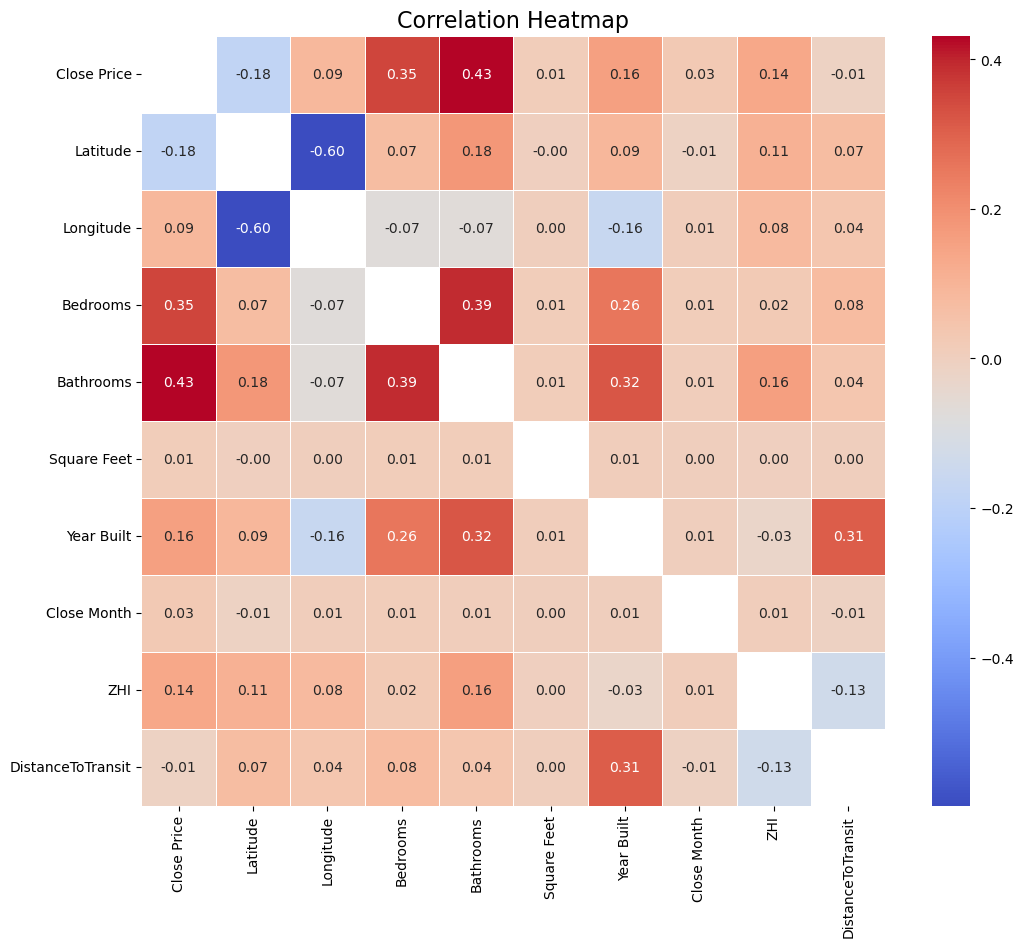

Correlation of features with Close Price:
Bathrooms            0.431688
Bedrooms             0.354058
Year Built           0.157001
ZHI                  0.136002
Longitude            0.089701
Close Month          0.025670
Square Feet          0.011270
DistanceToTransit   -0.011558
Latitude            -0.180385
Name: Close Price, dtype: float64


In [21]:
# now we will add a correlation heatmap with just the diagonal entries masked out 
import seaborn as sns
import matplotlib.pyplot as plt     
# Select only numeric columns for correlation
numeric_cols = final_df.select_dtypes(include=[np.number]).columns
corr_matrix = final_df[numeric_cols].corr()
# Create a mask for the upper triangle
mask = np.identity(corr_matrix.shape[0])
# Set up the matplotlib figure
plt.figure(figsize=(12, 10))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap', fontsize=16)
plt.show()  
# lets also look at the correlation of the target variable with the other features
target_corr = corr_matrix[target_col].drop(target_col).sort_values(ascending=False)
print(f"Correlation of features with {target_col}:\n{target_corr}")

